# DoorDash Delivery Duration Prediction

## Feature Selection Notebook

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

historical_data = pd.read_csv('data/historical_data.csv')
train_df = pd.read_csv('data/train_df.csv')

In [2]:
def process_historical(historical_data):
    historical_data["created_at"] = pd.to_datetime(historical_data['created_at'])
    historical_data["actual_delivery_time"] = pd.to_datetime(historical_data['actual_delivery_time'])
    historical_data["actual_total_delivery_duration"] = (historical_data["actual_delivery_time"] - historical_data["created_at"]).dt.total_seconds()

    historical_data['estimated_non_prep_duration'] = historical_data["estimated_store_to_consumer_driving_duration"] + historical_data["estimated_order_place_duration"]

    historical_data["busy_dashers_ratio"] = historical_data["total_busy_dashers"] / historical_data["total_onshift_dashers"]

    store_id_unique = historical_data["store_id"].unique().tolist()
    store_id_and_category = {store_id: historical_data[historical_data.store_id == store_id].store_primary_category.mode() 
                            for store_id in store_id_unique}

    def fill(store_id):
        """Return primary store category from the dictionary"""
        try:
            return store_id_and_category[store_id].values[0]
        except:
            return np.nan

    # fill null values
    historical_data["nan_free_store_primary_category"] = historical_data.store_id.apply(fill)

    return historical_data

historical_data = process_historical(historical_data)

order_protocol_dummies = pd.get_dummies(historical_data.order_protocol)
order_protocol_dummies = order_protocol_dummies.add_prefix('order_protocol_')

market_id_dummies = pd.get_dummies(historical_data.market_id)
market_id_dummies = market_id_dummies.add_prefix('market_id_')

store_primary_category_dummies = pd.get_dummies(historical_data.nan_free_store_primary_category)
store_primary_category_dummies = store_primary_category_dummies.add_prefix('category_')

### Removing Redundant and Collinear Features

We have 100 columns in our final dataset, which means there might be redundant features. These features are not useful in a way by repeating another feature or having a zero standard deviation. Therefore, doesn't add any new knowledge to ML models. Another potential problem is collinearity. We will check all of them. We start with the correlation matrix.

<Axes: >

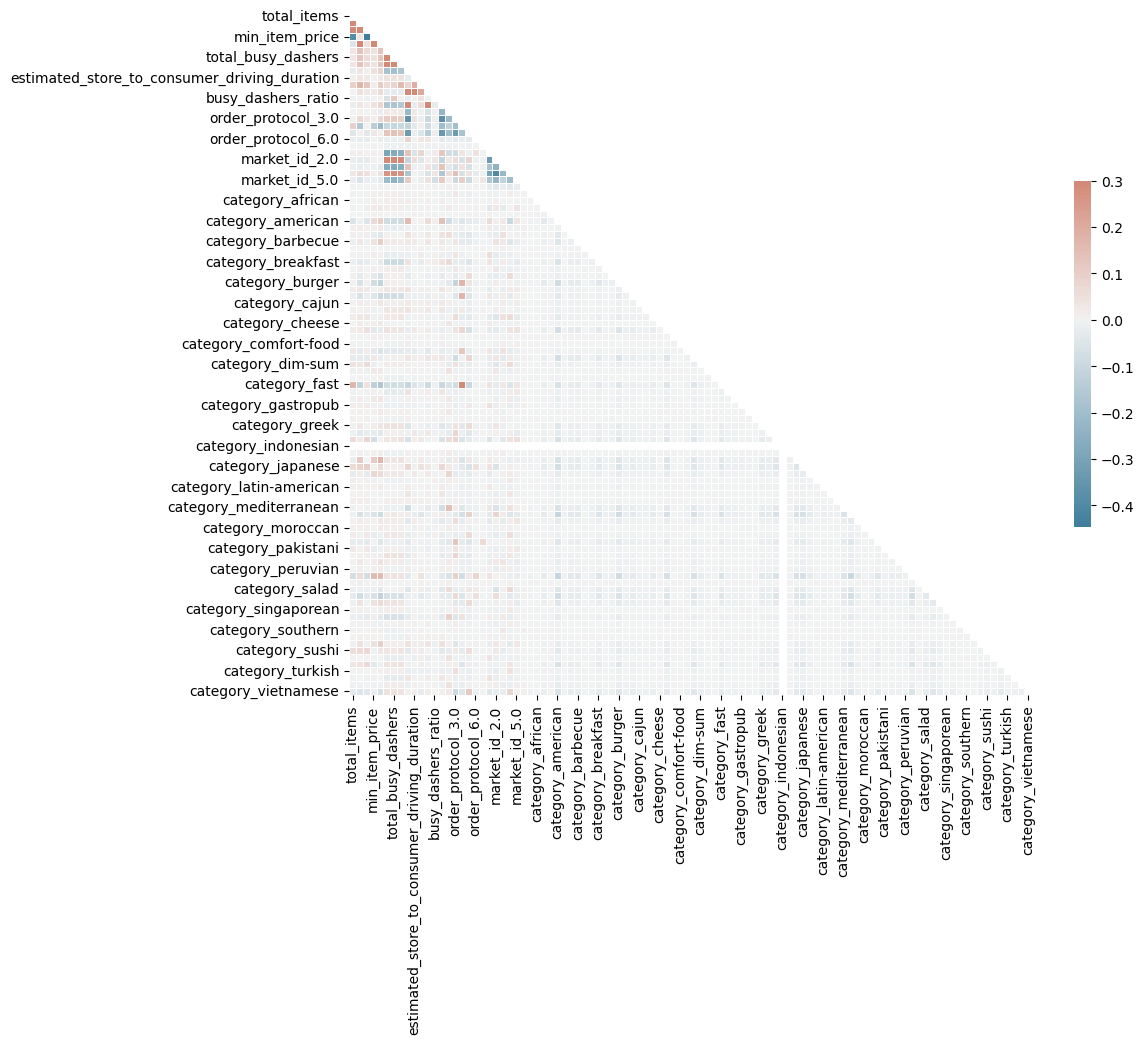

In [3]:
# cell might take a while to run since we'll be creating a correlation matrix

# create a mask
corr = train_df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(11, 9))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

We can see that we get blank squares for `category_indonesian`. Check with `.describe()`

In [4]:
train_df['category_indonesian'].describe()

count    177070.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: category_indonesian, dtype: float64

Nothing really we can do with the info it's giving us, we can drop it. Instead of just dropping that feature alone, we'll create some functions to see the top correlated features and drop the one of the redundant pairs.

In [5]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    '''Set correlations in the desscending order and return n highest results'''
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(train_df, 20))

Top Absolute Correlations
total_onshift_dashers                         total_busy_dashers             0.941741
                                              total_outstanding_orders       0.934639
total_busy_dashers                            total_outstanding_orders       0.931295
estimated_store_to_consumer_driving_duration  estimated_non_prep_duration    0.923086
estimated_order_place_duration                order_protocol_1.0             0.897645
total_items                                   num_distinct_items             0.758146
subtotal                                      num_distinct_items             0.682890
total_items                                   subtotal                       0.557175
min_item_price                                max_item_price                 0.541241
subtotal                                      max_item_price                 0.507947
order_protocol_4.0                            category_fast                  0.489946
num_distinct_items          

We have highly correlated features. We can drop some columns based on how much its information could be captured by other features. Firstly, `total_busy_dashers` and `total_onshift_dashers` are actually represented by `busy_dashers_ratio`. We can drop them off. Secondly, `estimated_non_prep_duation` - we created this feature - is correlated with driving and order place duration. We can keep the original value and drop the created one. Additionally, market id values are also on the list as being correlated with each other. As same with all kinds of colliniearities, these are potential suspects to hurt the regression performance. We won't concat them into the dataframe anymore. Let's do it and check the correlations again.

In [6]:
# drop created_at, market_id, store_id, store_primary_category, actual_delivery_time, ordfer_protocol
train_df = historical_data.drop(columns=['created_at', 'market_id', 'store_id', 'store_primary_category', 'actual_delivery_time',
                          'nan_free_store_primary_category', 'order_protocol'])

train_df = pd.concat([train_df, order_protocol_dummies, store_primary_category_dummies], axis=1)

train_df = train_df.drop(columns=['total_onshift_dashers', 'total_busy_dashers', 'category_indonesian',
                          'estimated_non_prep_duration'])

train_df = train_df.astype("float32")
# replace inf values with nan to drtop all nans
train_df.replace([np.inf, -np.inf], np.nan, inplace=True)
train_df.dropna(inplace=True)
train_df.head()

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,actual_total_delivery_duration,busy_dashers_ratio,...,category_southern,category_spanish,category_steak,category_sushi,category_tapas,category_thai,category_turkish,category_vegan,category_vegetarian,category_vietnamese
0,4.0,3441.0,4.0,557.0,1239.0,21.0,446.0,861.0,3779.0,0.424242,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1900.0,1.0,1400.0,1400.0,2.0,446.0,690.0,4024.0,2.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1900.0,1.0,1900.0,1900.0,0.0,446.0,690.0,1781.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6.0,6900.0,5.0,600.0,1800.0,2.0,446.0,289.0,3075.0,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.0,3900.0,3.0,1100.0,1600.0,9.0,446.0,650.0,2390.0,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
train_df.shape

(177070, 90)

In [8]:
print("Top Absolute Correlations")
print(get_top_abs_correlations(train_df, 20))

Top Absolute Correlations
estimated_order_place_duration  order_protocol_1.0    0.897645
total_items                     num_distinct_items    0.758146
subtotal                        num_distinct_items    0.682890
total_items                     subtotal              0.557175
min_item_price                  max_item_price        0.541241
subtotal                        max_item_price        0.507947
order_protocol_4.0              category_fast         0.489946
num_distinct_items              min_item_price        0.446733
total_items                     min_item_price        0.389277
order_protocol_1.0              order_protocol_3.0    0.373581
estimated_order_place_duration  order_protocol_3.0    0.364170
order_protocol_1.0              order_protocol_5.0    0.342345
estimated_order_place_duration  order_protocol_5.0    0.333291
order_protocol_3.0              order_protocol_5.0    0.332533
order_protocol_1.0              order_protocol_2.0    0.226903
estimated_order_place_duratio

Order protocols seem to be highly correlated with each other so we won't concatenate them. Repeat the same process we did above.

In [9]:
# drop created_at, market_id, store_id, store_primary_category, actual_delivery_time, ordfer_protocol
train_df = historical_data.drop(columns=['created_at', 'market_id', 'store_id', 'store_primary_category', 'actual_delivery_time',
                          'nan_free_store_primary_category', 'order_protocol'])

train_df = pd.concat([train_df, store_primary_category_dummies], axis=1)

train_df = train_df.drop(columns=['total_onshift_dashers', 'total_busy_dashers', 'category_indonesian',
                          'estimated_non_prep_duration'])

train_df = train_df.astype("float32")
# replace inf values with nan to drtop all nans
train_df.replace([np.inf, -np.inf], np.nan, inplace=True)
train_df.dropna(inplace=True)
train_df.head()

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,actual_total_delivery_duration,busy_dashers_ratio,...,category_southern,category_spanish,category_steak,category_sushi,category_tapas,category_thai,category_turkish,category_vegan,category_vegetarian,category_vietnamese
0,4.0,3441.0,4.0,557.0,1239.0,21.0,446.0,861.0,3779.0,0.424242,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1900.0,1.0,1400.0,1400.0,2.0,446.0,690.0,4024.0,2.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1900.0,1.0,1900.0,1900.0,0.0,446.0,690.0,1781.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6.0,6900.0,5.0,600.0,1800.0,2.0,446.0,289.0,3075.0,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.0,3900.0,3.0,1100.0,1600.0,9.0,446.0,650.0,2390.0,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
print("Top Absolute Correlations")
print(get_top_abs_correlations(train_df, 20))

Top Absolute Correlations
total_items                                   num_distinct_items                0.758146
subtotal                                      num_distinct_items                0.682890
total_items                                   subtotal                          0.557175
min_item_price                                max_item_price                    0.541241
subtotal                                      max_item_price                    0.507947
num_distinct_items                            min_item_price                    0.446733
total_items                                   min_item_price                    0.389277
estimated_store_to_consumer_driving_duration  actual_total_delivery_duration    0.188418
subtotal                                      actual_total_delivery_duration    0.172312
total_outstanding_orders                      estimated_order_place_duration    0.171049
total_items                                   category_fast                     0.17

Still, we have some features with high correlations. The total item number or distinct items could affect the duration of the preparation process. Therefore, we do not prefer to drop them. Instead, we can use the power of feature engineering. We will create new columns to infer the contribution of these columns.

In [11]:
# creating new features
train_df['percent_distinct_item_of_total'] = train_df["num_distinct_items"] / train_df["total_items"]
train_df["avg_price_per_item"] = train_df["subtotal"] / train_df["total_items"]
train_df.drop(columns=["num_distinct_items", "subtotal"], inplace=True)
print("Top Absolute Correlations")
print(get_top_abs_correlations(train_df, 20))

Top Absolute Correlations
min_item_price                                avg_price_per_item                0.860580
max_item_price                                avg_price_per_item                0.770382
min_item_price                                max_item_price                    0.541241
total_items                                   percent_distinct_item_of_total    0.445751
                                              min_item_price                    0.389277
                                              avg_price_per_item                0.310759
percent_distinct_item_of_total                avg_price_per_item                0.226711
category_pizza                                avg_price_per_item                0.225510
estimated_store_to_consumer_driving_duration  actual_total_delivery_duration    0.188418
max_item_price                                percent_distinct_item_of_total    0.178021
category_fast                                 avg_price_per_item                0.17

We will apply a similar trick for min and max item prices.

In [12]:
train_df["price_range_of_items"] = train_df["max_item_price"] - train_df["min_item_price"]
train_df.drop(columns=["max_item_price", "min_item_price"], inplace=True)
print("Top Absolute Correlations")
print(get_top_abs_correlations(train_df, 20))

Top Absolute Correlations
total_items                                   percent_distinct_item_of_total    0.445751
                                              price_range_of_items              0.333304
                                              avg_price_per_item                0.310759
percent_distinct_item_of_total                avg_price_per_item                0.226711
category_pizza                                avg_price_per_item                0.225510
estimated_store_to_consumer_driving_duration  actual_total_delivery_duration    0.188418
category_fast                                 avg_price_per_item                0.175950
total_outstanding_orders                      estimated_order_place_duration    0.171049
total_items                                   category_fast                     0.170988
category_italian                              avg_price_per_item                0.158193
total_outstanding_orders                      actual_total_delivery_duration    0.15

We solved the main issues with correlation. We are done with feature engineering now. We can officially apply a multicollinearity check in the next step. We reduced our number of columns to 82.

In [13]:
train_df.shape

(177070, 82)

### Multicollinearity Check

We will do the multicollinearity check through Variance Inflation Factor (VIF). We will eliminate all features taht have VIF scores above 20. For each iteration, we will drop only one feature since when the feature set is changed, the VIF score changes.

In [14]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [15]:
def compute_vif(features):
    '''Compute the VIF score using the variance_inflation_factor() function'''
    vif_data = pd.DataFrame()
    vif_data["features"] = features
    vif_data["VIF"] = [variance_inflation_factor(train_df[features].values, i) for i in range(len(features))]
    return vif_data.sort_values(by=["VIF"]).reset_index(drop=True)

The run time of the next cell could be long, which is normal. It will calculate a VIF score for each column

In [16]:
# apply VIF computation to all columns
features = train_df.drop(columns=['actual_total_delivery_duration']).columns.to_list()
vif_data = compute_vif(features)
vif_data

,features,VIF
0,category_alcohol-plus-food,1.000371
1,category_chocolate,1.000498
2,category_belgian,1.000760
3,category_russian,1.003231
4,category_african,1.003823
...,...,...
76,busy_dashers_ratio,6.369601
77,category_american,7.033604
78,estimated_store_to_consumer_driving_duration,7.210844
79,estimated_order_place_duration,13.472279


We still have a multicollinearity problem despite our feature engineering efforts. We will drop the columns with a VIF score over our specified threshold.

In [17]:
# drop the highest VIF score until all VIF scores are below 20
multicollinearity = True

while multicollinearity:
    highest_vif_feature = vif_data['features'].values.tolist()[-1]
    print("Remove", highest_vif_feature)
    features.remove(highest_vif_feature)
    vif_data = compute_vif(features)
    multicollinearity = False if len(vif_data[vif_data['VIF'] > 20]) == 0 else True

selected_features = vif_data['features'].values.tolist()
vif_data

Remove percent_distinct_item_of_total


,features,VIF
0,category_alcohol-plus-food,1.000222
1,category_chocolate,1.000369
2,category_belgian,1.000461
3,category_russian,1.002022
4,category_gluten-free,1.002372
...,...,...
75,category_american,4.505928
76,avg_price_per_item,5.958972
77,busy_dashers_ratio,6.357889
78,estimated_store_to_consumer_driving_duration,7.192644


We can see that it was enough to remove `percent_distinct_item_of_total`.

### Feature Selection

We have a rich feature set. To reduce the noise in the model and decrease the training duration, we can use a subset of these features in the modeling part. Therefore, we will investigate the feature importances. First, we use RandomForestRegressor to get the importance of each feature in the prediction of the actual total delivery duration.

In [18]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# selected features are selected in multicollinearity part
X = train_df[selected_features]
y = train_df['actual_total_delivery_duration']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

After fitting the model, let's sort all of the features based on their importance and visualize them

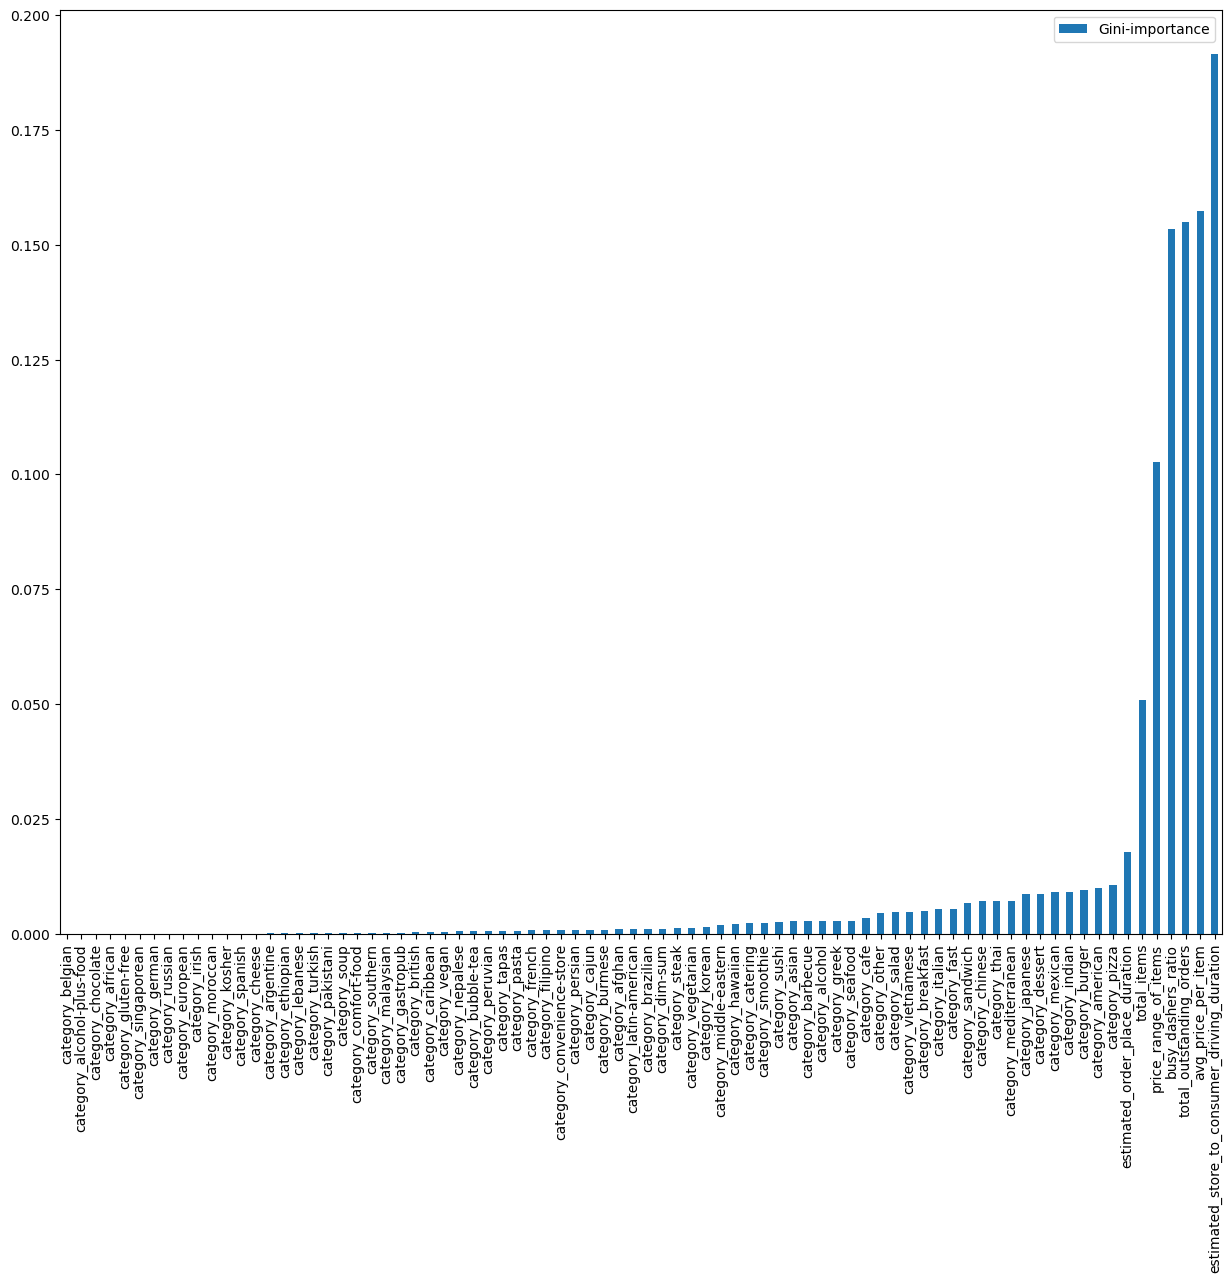

In [19]:
feature_names = [f"feature {i}" for i in range(X_train.shape[1])]
forest = RandomForestRegressor(n_estimators=100, random_state=42)
forest.fit(X_train, y_train)
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X.columns, forest.feature_importances_):
    feats[feature] = importance #add the name/value pair

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values(by='Gini-importance').plot(kind='bar', rot=90, figsize=(15, 12))
plt.show();

Many of the features have a very marginal contribution to regression. Let's check just the ones that matter...

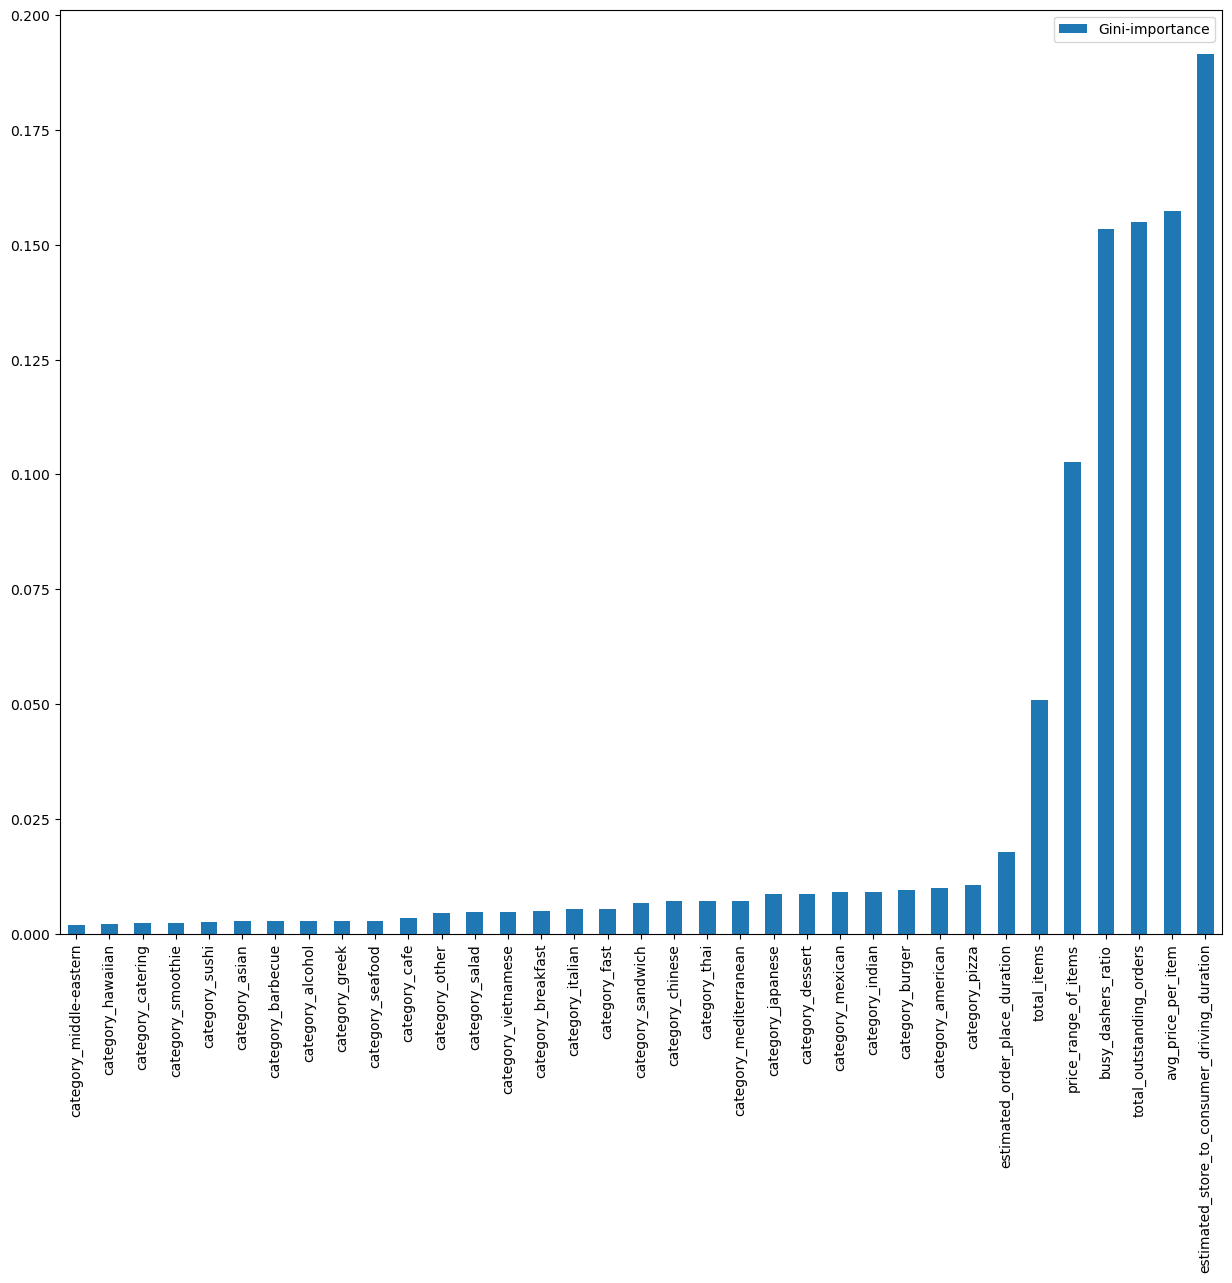

In [20]:
importances.sort_values(by='Gini-importance')[-35:].plot(kind='bar', rot=90, figsize=(15, 12))
plt.show();

As expected, estimated store-to-consumer driving duration is very important to overall delivery duration. Busy dashers ratio, total outstanding orders, and average price per item are also highly contributed features. We can choose our final features subset using these importances.

In [21]:
# we can obtain the column names as next
importances.sort_values(by='Gini-importance')[-35:].index.tolist()

['category_middle-eastern',
 'category_hawaiian',
 'category_catering',
 'category_smoothie',
 'category_sushi',
 'category_asian',
 'category_barbecue',
 'category_alcohol',
 'category_greek',
 'category_seafood',
 'category_cafe',
 'category_other',
 'category_salad',
 'category_vietnamese',
 'category_breakfast',
 'category_italian',
 'category_fast',
 'category_sandwich',
 'category_chinese',
 'category_thai',
 'category_mediterranean',
 'category_japanese',
 'category_dessert',
 'category_mexican',
 'category_indian',
 'category_burger',
 'category_american',
 'category_pizza',
 'estimated_order_place_duration',
 'total_items',
 'price_range_of_items',
 'busy_dashers_ratio',
 'total_outstanding_orders',
 'avg_price_per_item',
 'estimated_store_to_consumer_driving_duration']

Another method to decrease feature dimension is PCA (Principal Component Analysis). It maps all features to another plain and obtains the most representative interpretations to explain all variances in the DataFrame.

/var/folders/xs/d1td623j4l5_3s9p262jr4yw0000gn/T/ipykernel_45976/905817532.py:11: MatplotlibDeprecationWarning: Passing the emit parameter of set_xlim() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  plt.xlim(0,81,1)


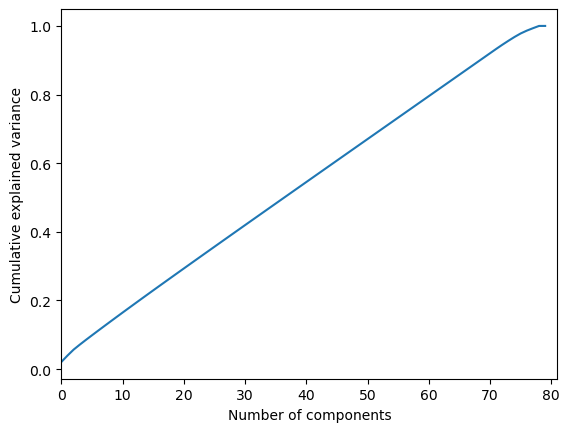

In [22]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X_Train=X_train.values
X_Train=np.asarray(X_Train)

# Finding normalised array of X_Train
X_std=StandardScaler().fit_transform(X_Train)
pca = PCA().fit(X_std)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlim(0,81,1)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show();

PCA shows that we need to use at least 60 representative features to explain 80% of the dataset, which makes the PCA transformation useless since we already have 80 and could select the most important ones based on feature importance. However, if PCA would tell us it can explain the majority of variance with around 10 features - high reduction - we would continue with it.

### Apply Scaler

We are done with features. We'll move to the modelling part. As we see in data exploration part, we have great differences between minimum and maximum values within the dataframe. It is a good motivation to use scaler for the sake of regression performance. We have different options to use as scaler. So, we implement a generic function that could use any sklearn scaler. We will use MinMaxScaler and StandardScaler to see if there is any performance difference between them for our dataframe.

In [23]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

def scale(scaler, X, y):
    """Apply the selected scaler to features and target variables"""
    X_scaler = scaler
    X_scaler.fit(X=X, y=y)
    X_scaled = X_scaler.transform(X)
    y_scaler = scaler
    y_scaler.fit(y.values.reshape(-1, 1))
    y_scaled = y_scaler.transform(y.values.reshape(-1, 1))
    
    return X_scaled, y_scaled, X_scaler, y_scaler

In [24]:
# example
X_scaled, y_scaled, X_scaler, y_scaler = scale(MinMaxScaler(), X, y)

In [25]:
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

### Inverse Transform for Metric Comparison

Since we applied a scaler to training data, the predictions for test data will also be scaled. And to see the error in terms of seconds, we need to apply the inverse transformation. We will use Root Mean Squared Error to measure error. We could also use Mean Squared Error or Mean Absolute Error. We gave our decision based on the sensitivity of RMSE for high error terms. In our thought, the consumer patience with delaying delivery could decrease exponentially with time.

In [26]:
from sklearn.metrics import mean_squared_error

def rmse_with_inv_transform(scaler, y_test, y_pred_scaled, model_name):
    '''Convert the scaled error to actual error'''
    y_predict = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))
    # return RMSE with squared error
    rmse_error = mean_squared_error(y_test, y_predict[:, 0], squared=False)
    print("Error = {}".format(rmse_error)+" in " + model_name)
    return rmse_error, y_predict

### Classical Machine Learning

Since we have no prior knowledge about which regressor has the best performance with our problem, we wil try several of them. Therefore, we implement a generic regressino function below, which could work with different regression models.

In [27]:
def make_regression(X_train, y_train, X_test, y_test, model, model_name, verbose=True):
    """Apply selected regression model to data and measure error"""
    model.fit(X_train, y_train)
    y_predict = model.predict(X_train)
    train_error = mean_squared_error(y_train, y_predict, squared=False)
    y_predict = model.predict(X_test)
    test_error = mean_squared_error(y_test, y_predict, squared=False)
    if verbose:
        print("Train Error = {}".format(train_error)+" in " + model_name)
        print("Test Error = {}".format(test_error)+" in " + model_name)
    trained_model = model

    return trained_model, y_predict, train_error, test_error

We will experiment with different regression models, feature sets, and scalers. We will store the error rate for each model in `pred_dict`. Then, we'll plot performance. It's necessary to see what works best for higher performance.

In [28]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.neural_network import MLPRegressor
from sklearn import tree
from sklearn import svm
from sklearn import neighbors
from sklearn import linear_model

pred_dict = {
    "regression_model": [],
    "feature_set": [],
    "scaler_name": [],
    "RMSE": [],
}

regression_models = {
    "Ridge": linear_model.Ridge(),
    "DecisionTree": tree.DecisionTreeRegressor(max_depth=6),
    "RandomForestRegressor": RandomForestRegressor(),
    "XGBoost": XGBRegressor(),
    "LGBM": LGBMRegressor(),
    "MLP": MLPRegressor(),
}

feature_sets = {
    "full_dataset": X.columns.to_list(),
    "selected_features_40": importances.sort_values(by='Gini-importance')[-40:].index.tolist(),
    "selected_features_20": importances.sort_values(by='Gini-importance')[-20:].index.tolist(),
    "selected_features_10": importances.sort_values(by='Gini-importance')[-10:].index.tolist(),
}

scalers = {
    "Standard scaler": StandardScaler(),
    "MinMax scaler": MinMaxScaler(),
    "NotScale": None,
}

for feature_set_name in feature_sets.keys():
    feature_set = feature_sets[feature_set_name]
    for scaler_name in scalers.keys():
        print(f"-----scaled with {scaler_name}-------- included columns are {feature_set_name}")
        print("")
        for model_name in regression_models.keys():   
            if scaler_name == "NotScale":
                X = train_df[feature_set]
                y = train_df["actual_total_delivery_duration"]
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
                make_regression(X_train, y_train, X_test, y_test, regression_models[model_name], model_name, verbose=True)
            
            else:
                
                X_scaled, y_scaled, X_scaler, y_scaler = scale(scalers[scaler_name], X[feature_set], y)
                X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(
                    X_scaled, y_scaled, test_size=0.2, random_state=42)
                _, y_predict_scaled, _, _ = make_regression(X_train_scaled, y_train_scaled[:,0], X_test_scaled, y_test_scaled[:,0], regression_models[model_name], model_name, verbose=False)
                rmse_error, y_predict = rmse_with_inv_transform(y_scaler, y_test, y_predict_scaled, model_name)

            pred_dict["regression_model"].append(model_name)
            pred_dict["feature_set"].append(feature_set_name)
            pred_dict["scaler_name"].append(scaler_name)
            pred_dict["RMSE"].append(rmse_error)

-----scaled with Standard scaler-------- included columns are full_dataset

Error = 2053.69873046875 in Ridge
Error = 2057.2476687088733 in DecisionTree
Error = 2048.6274073256163 in RandomForestRegressor
Error = 2036.2498779296875 in XGBoost
Error = 2033.4355809987908 in LGBM
Error = 2036.7987060546875 in MLP
-----scaled with MinMax scaler-------- included columns are full_dataset

Error = 2053.962890625 in Ridge
Error = 2057.2476685732177 in DecisionTree
Error = 2048.5025263053903 in RandomForestRegressor
Error = 2035.351318359375 in XGBoost
Error = 2034.4499976619875 in LGBM
Error = 2119.4794921875 in MLP
-----scaled with NotScale-------- included columns are full_dataset



/Users/jordansamek/opt/miniconda3/envs/doordash_env/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=4.42528e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Train Error = 1071.4970703125 in Ridge
Test Error = 2053.692626953125 in Ridge
Train Error = 1067.7815291116704 in DecisionTree
Test Error = 2057.2476684096064 in DecisionTree
Train Error = 396.4889439565693 in RandomForestRegressor
Test Error = 2048.171238919613 in RandomForestRegressor
Train Error = 968.2471313476562 in XGBoost
Test Error = 2036.43212890625 in XGBoost
Train Error = 1017.5549840201221 in LGBM
Test Error = 2034.461097275308 in LGBM


/Users/jordansamek/opt/miniconda3/envs/doordash_env/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Train Error = 1056.7137451171875 in MLP
Test Error = 2047.4556884765625 in MLP
-----scaled with Standard scaler-------- included columns are selected_features_40

Error = 2054.00439453125 in Ridge
Error = 2056.5292024696128 in DecisionTree
Error = 2049.460781692858 in RandomForestRegressor
Error = 2035.453369140625 in XGBoost
Error = 2034.6538984910121 in LGBM
Error = 2036.656005859375 in MLP
-----scaled with MinMax scaler-------- included columns are selected_features_40

Error = 2054.27734375 in Ridge
Error = 2056.5292023632996 in DecisionTree
Error = 2048.110805757111 in RandomForestRegressor
Error = 2034.2847900390625 in XGBoost
Error = 2035.196536738781 in LGBM
Error = 2148.044921875 in MLP
-----scaled with NotScale-------- included columns are selected_features_40

Train Error = 1072.35498046875 in Ridge
Test Error = 2054.00439453125 in Ridge


/Users/jordansamek/opt/miniconda3/envs/doordash_env/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.55922e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Train Error = 1067.785563647774 in DecisionTree
Test Error = 2056.529202224364 in DecisionTree
Train Error = 397.27625940517925 in RandomForestRegressor
Test Error = 2048.1196819927004 in RandomForestRegressor
Train Error = 965.6858520507812 in XGBoost
Test Error = 2035.7642822265625 in XGBoost
Train Error = 1017.1430421117441 in LGBM
Test Error = 2034.8058530174258 in LGBM


/Users/jordansamek/opt/miniconda3/envs/doordash_env/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Train Error = 1057.3214111328125 in MLP
Test Error = 2049.19482421875 in MLP
-----scaled with Standard scaler-------- included columns are selected_features_20

Error = 2055.36572265625 in Ridge
Error = 2054.610311207463 in DecisionTree
Error = 2049.891039154913 in RandomForestRegressor
Error = 2037.6336669921875 in XGBoost
Error = 2036.0233846729805 in LGBM
Error = 2036.7449951171875 in MLP
-----scaled with MinMax scaler-------- included columns are selected_features_20

Error = 2055.653076171875 in Ridge
Error = 2054.6103112689557 in DecisionTree
Error = 2048.330434137417 in RandomForestRegressor
Error = 2036.5164794921875 in XGBoost
Error = 2035.581516471472 in LGBM
Error = 2143.33056640625 in MLP
-----scaled with NotScale-------- included columns are selected_features_20

Train Error = 1074.506591796875 in Ridge
Test Error = 2055.36572265625 in Ridge


/Users/jordansamek/opt/miniconda3/envs/doordash_env/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=4.43857e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Train Error = 1069.1350906055598 in DecisionTree
Test Error = 2054.610311170708 in DecisionTree
Train Error = 398.29878969685063 in RandomForestRegressor
Test Error = 2049.937112560083 in RandomForestRegressor
Train Error = 966.1651000976562 in XGBoost
Test Error = 2036.249267578125 in XGBoost
Train Error = 1018.9600610110249 in LGBM
Test Error = 2035.9494403356318 in LGBM


/Users/jordansamek/opt/miniconda3/envs/doordash_env/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Train Error = 1057.6685791015625 in MLP
Test Error = 2048.466552734375 in MLP
-----scaled with Standard scaler-------- included columns are selected_features_10

Error = 2056.568359375 in Ridge
Error = 2054.5971761770547 in DecisionTree
Error = 2050.2148344853 in RandomForestRegressor
Error = 2040.27001953125 in XGBoost
Error = 2038.1313604554389 in LGBM
Error = 2040.0670166015625 in MLP
-----scaled with MinMax scaler-------- included columns are selected_features_10

Error = 2056.882080078125 in Ridge
Error = 2054.5971762373274 in DecisionTree
Error = 2051.718974264131 in RandomForestRegressor
Error = 2039.515625 in XGBoost
Error = 2037.6564489201091 in LGBM
Error = 2063.877197265625 in MLP
-----scaled with NotScale-------- included columns are selected_features_10

Train Error = 1076.7279052734375 in Ridge
Test Error = 2056.568359375 in Ridge
Train Error = 1069.2324011708552 in DecisionTree
Test Error = 2054.597176140608 in DecisionTree
Train Error = 398.5247938831995 in RandomForest

In [29]:
pred_df = pd.DataFrame(pred_dict)
pred_df

,regression_model,feature_set,scaler_name,RMSE
0,Ridge,full_dataset,Standard scaler,2053.698730
1,DecisionTree,full_dataset,Standard scaler,2057.247669
2,RandomForestRegressor,full_dataset,Standard scaler,2048.627407
3,XGBoost,full_dataset,Standard scaler,2036.249878
4,LGBM,full_dataset,Standard scaler,2033.435581
...,...,...,...,...
67,DecisionTree,selected_features_10,NotScale,2063.877197
68,RandomForestRegressor,selected_features_10,NotScale,2063.877197
69,XGBoost,selected_features_10,NotScale,2063.877197
70,LGBM,selected_features_10,NotScale,2063.877197


<Axes: >

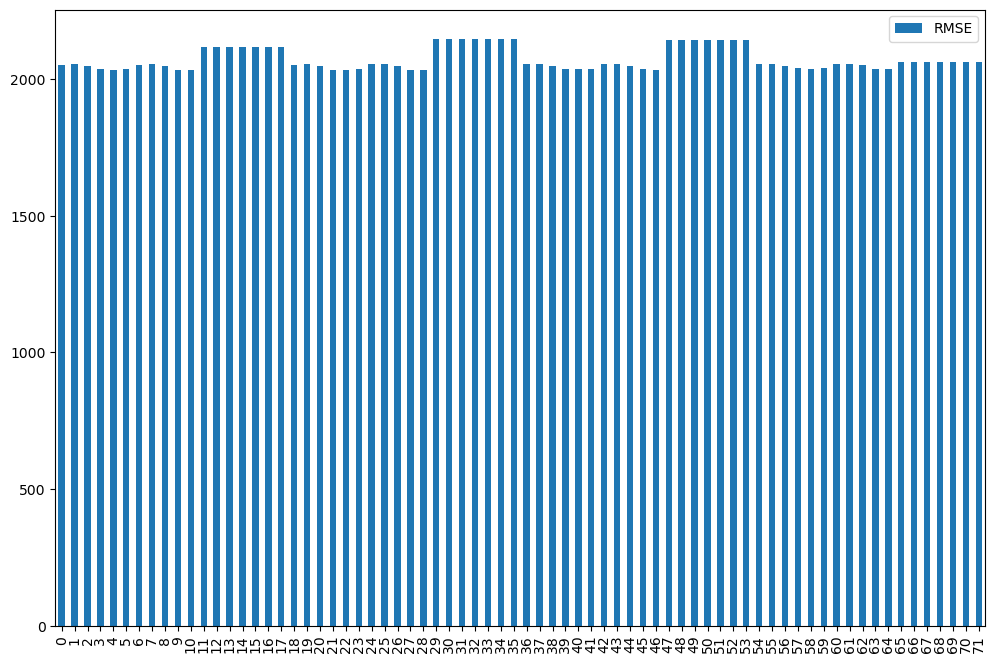

In [30]:
pred_df.plot(kind='bar', figsize=(12, 8))

It seems we have high errors through all models. Also, the models inform us to not scale affects the performance. We could pick one of the scalers and continue since it doesn't affect the performance much. The decrease in training feature size first slightly improves the performance and then marginally made it worse. We choose to use 40 as a final decision. When we examine the model performances, the most significant thing is the error rates. What could we do more to improve it? Could it be our dataset is not a good representation for estimating the total delivery duration? One idea could be predicting preparation time and using the given estimated store-to-consumer driving ratio and order place, to sum up, and find the total delivery duration. Let's try it.

In [31]:
# change the problem as stated above

train_df["prep_time"] = train_df["actual_total_delivery_duration"] - train_df["estimated_store_to_consumer_driving_duration"] - train_df["estimated_order_place_duration"]

# not scaling affects the performance so we will continue to scale but it doesn't really matter which scaler we use
scalers = {
    "Standard scaler": StandardScaler(),
}

feature_sets = {
    "selected_features_40": importances.sort_values(by='Gini-importance')[-40:].index.tolist(),
}

for featue_set_name in feature_sets.keys():
    feature_set = feature_sets[featue_set_name]
    for scaler_name in scalers.keys():
        print(f"-----scaled with {scaler_name}-------- included columns are {feature_set_name}")
        print("")
        for model_name in regression_models.keys():  
            #drop estimated_store_to_consumer_driving_duration and estimated_order_place_duration
            X = train_df[feature_set].drop(columns=["estimated_store_to_consumer_driving_duration", 
                                           "estimated_order_place_duration"])
            y = train_df["prep_time"]
            
            # to get indices
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
            train_indices = X_train.index
            test_indices  = X_test.index
            
            # scale
            X_scaled, y_scaled, X_scaler, y_scaler = scale(scalers[scaler_name], X, y)
            
            # apply indexing
            X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)
            _, y_predict_scaled, _, _ = make_regression(X_train_scaled, y_train_scaled[:,0], X_test_scaled, y_test_scaled[:,0], regression_models[model_name], model_name, verbose=False)
            rmse_error, y_predict = rmse_with_inv_transform(y_scaler, y_test, y_predict_scaled, model_name)
            pred_dict["regression_model"].append(model_name)
            pred_dict["feature_set"].append(feature_set_name)
            pred_dict["scaler_name"].append(scaler_name)
            pred_dict["RMSE"].append(rmse_error)

-----scaled with Standard scaler-------- included columns are selected_features_10

Error = 2055.407470703125 in Ridge
Error = 2045.9600605629953 in DecisionTree
Error = 2045.511521597619 in RandomForestRegressor
Error = 2037.8203125 in XGBoost
Error = 2035.7236370573405 in LGBM
Error = 2038.620849609375 in MLP


In [35]:
# not scaling affects the performance so we will continue to scale but it doesn't really matter which scaler we use

scalers = {
    "Standard scaler": StandardScaler(),
}

feature_sets = {
    "selected_features_40": importances.sort_values(by='Gini-importance')[-40:].index.tolist(),
}

regression_models = {
    "LGBM": LGBMRegressor(),
}

for feature_set_name in feature_sets.keys():
    feature_set = feature_sets[feature_set_name]
    for scaler_name in scalers.keys():
        print(f"-----scaled with {scaler_name}-------- included columns are {feature_set_name}")
        print("")
        for model_name in regression_models.keys():  
            #drop estimated_store_to_consumer_driving_duration and estimated_order_place_duration
            X = train_df[feature_set].drop(columns=["estimated_store_to_consumer_driving_duration", 
                                           "estimated_order_place_duration"])
            y = train_df["prep_time"]
            
            # to get indices
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
            train_indices = X_train.index
            test_indices  = X_test.index
            
            # scale
            X_scaled, y_scaled, X_scaler, y_scaler = scale(scalers[scaler_name], X, y)
            
            # apply indexing
            X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)
            _, y_predict_scaled, _, _ = make_regression(X_train_scaled, y_train_scaled[:,0], X_test_scaled, y_test_scaled[:,0], regression_models[model_name], model_name, verbose=False)
            rmse_error, y_predict = rmse_with_inv_transform(y_scaler, y_test, y_predict_scaled, model_name)
            pred_dict["regression_model"].append(model_name)
            pred_dict["feature_set"].append(feature_set_name)
            pred_dict["scaler_name"].append(scaler_name)
            pred_dict["RMSE"].append(rmse_error)

-----scaled with Standard scaler-------- included columns are selected_features_40

Error = 2035.7236370573405 in LGBM


In [36]:
# choosing the best performing model and extract predictions fro preparation duration

pred_values_dict = {
    "actual_total_delivery_duration": train_df["actual_total_delivery_duration"][test_indices].values.tolist(),
    "prep_duration_prediction": y_predict[:, 0].tolist(),
    "estimated_store_to_consumer_driving_duration": train_df["estimated_store_to_consumer_driving_duration"][test_indices].values.tolist(),
    "estimated_order_place_duration": train_df["estimated_order_place_duration"][test_indices].values.tolist(),
}

In [37]:
# convert to dataframe
values_df = pd.DataFrame(pred_values_dict)
values_df

,actual_total_delivery_duration,prep_duration_prediction,estimated_store_to_consumer_driving_duration,estimated_order_place_duration
0,2448.0,1734.115287,380.0,251.0
1,1839.0,1508.588146,747.0,446.0
2,1927.0,2141.085685,543.0,251.0
3,2657.0,1312.559865,445.0,251.0
4,3596.0,1945.871826,691.0,446.0
...,...,...,...,...
35409,9557.0,2623.132706,768.0,446.0
35410,1864.0,2148.159250,324.0,446.0
35411,2674.0,1939.286320,791.0,251.0
35412,2234.0,1930.656157,687.0,251.0


In [38]:
# sum predictions with no preparation activities such as order placing and driving
values_df["sum_total_delivery_duration"] = values_df["prep_duration_prediction"] + values_df["estimated_store_to_consumer_driving_duration"] + values_df["estimated_order_place_duration"]
values_df

,actual_total_delivery_duration,prep_duration_prediction,estimated_store_to_consumer_driving_duration,estimated_order_place_duration,sum_total_delivery_duration
0,2448.0,1734.115287,380.0,251.0,2365.115287
1,1839.0,1508.588146,747.0,446.0,2701.588146
2,1927.0,2141.085685,543.0,251.0,2935.085685
3,2657.0,1312.559865,445.0,251.0,2008.559865
4,3596.0,1945.871826,691.0,446.0,3082.871826
...,...,...,...,...,...
35409,9557.0,2623.132706,768.0,446.0,3837.132706
35410,1864.0,2148.159250,324.0,446.0,2918.159250
35411,2674.0,1939.286320,791.0,251.0,2981.286320
35412,2234.0,1930.656157,687.0,251.0,2868.656157


In [39]:
mean_squared_error(values_df["actual_total_delivery_duration"], values_df["sum_total_delivery_duration"], squared=False)

2035.7236370573405

In [41]:
# what if we use another regression model to get the total delivery duration
X = values_df[["prep_duration_prediction", "estimated_store_to_consumer_driving_duration", "estimated_order_place_duration"]]
y = values_df["actual_total_delivery_duration"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [43]:
regression_models = {
    "LinearReg": linear_model.LinearRegression(),
    "Ridge": linear_model.Ridge(),
    "DecisionTree": tree.DecisionTreeRegressor(),
    "RandomForest": RandomForestRegressor(),
    "XGBoost": XGBRegressor(),
    "LGBM": LGBMRegressor(),
    "MLP": MLPRegressor(),
}

for model_name in regression_models.keys():
    _, y_predict, _, _ = make_regression(X_train, y_train, X_test, y_test, regression_models[model_name], model_name, verbose=False)
    print("RMSE of:",model_name, mean_squared_error(y_test,y_predict, squared=False))

RMSE of: LinearReg 986.6912510303843
RMSE of: Ridge 986.6912510344928
RMSE of: DecisionTree 1600.5287628019253
RMSE of: RandomForest 1196.764194590437
RMSE of: XGBoost 1370.412425918564
RMSE of: LGBM 1079.2949179771774
RMSE of: MLP 987.0723078514392


It seems like this approach has better performance. We can probably choose this as our final solution.

### Deep Learning

Could Artificial Neural Networks have a better performance for the given problem? The first intuition is that MLP performance was not better than tree-based regression in the preparation duration prediction part. Hence, we doubt it. However, MLP has a good performance on the prediction of actual total delivery using preparation, driving, and order place duration. Let's give it a try for this one!

In [44]:
import keras
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf
tf.random.set_seed(42)

# Neural network
def create_model(feature_set_size):
    
    # define the model
    model = Sequential()
    model.add(Dense(16, input_dim=feature_set_size, activation='relu'))
    model.add(Dense(1, activation='linear'))
    
    # compile the model
    model.compile(optimizer='sgd', loss='mse',
        metrics=[tf.keras.metrics.RootMeanSquaredError()])
    
    return model

2023-04-16 15:50:27.299534: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [45]:
print(f"-----scaled with {scaler_name}-------- included columns are {feature_set_name}")
print("")
model_name = "ANN"   
scaler_name = "Standard scaler"
X = values_df[["prep_duration_prediction", "estimated_store_to_consumer_driving_duration", "estimated_order_place_duration"]]
y = values_df["actual_total_delivery_duration"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_scaled, y_scaled, X_scaler, y_scaler = scale(scalers[scaler_name], X, y)
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(
    X_scaled, y_scaled, test_size=0.2, random_state=42)
print("feature_set_size:",X_train_scaled.shape[1])
model = create_model(feature_set_size=X_train_scaled.shape[1])
history = model.fit(X_train_scaled, y_train_scaled, epochs=100, batch_size=64, verbose=1)
y_pred = model.predict(X_test_scaled)
rmse_error = rmse_with_inv_transform(y_scaler, y_test, y_pred, model_name)
pred_dict["regression_model"].append(model_name)
pred_dict["feature_set"].append(feature_set_name)
pred_dict["scaler_name"].append(scaler_name)
pred_dict["RMSE"].append(rmse_error)

-----scaled with Standard scaler-------- included columns are selected_features_40

feature_set_size: 3
Epoch 1/100
443/443 [==============================] - 1s 1ms/step - loss: 1.1331 - root_mean_squared_error: 1.0645
Epoch 2/100
443/443 [==============================] - 1s 1ms/step - loss: 1.1196 - root_mean_squared_error: 1.0581
Epoch 3/100
443/443 [==============================] - 0s 1ms/step - loss: 1.1183 - root_mean_squared_error: 1.0575
Epoch 4/100
443/443 [==============================] - 0s 1ms/step - loss: 1.1186 - root_mean_squared_error: 1.0576
Epoch 5/100
443/443 [==============================] - 0s 1ms/step - loss: 1.1182 - root_mean_squared_error: 1.0574
Epoch 6/100
443/443 [==============================] - 1s 1ms/step - loss: 1.1182 - root_mean_squared_error: 1.0574
Epoch 7/100
443/443 [==============================] - 0s 1ms/step - loss: 1.1181 - root_mean_squared_error: 1.0574
Epoch 8/100
443/443 [==============================] - 0s 1ms/step - loss: 1.1177 - 

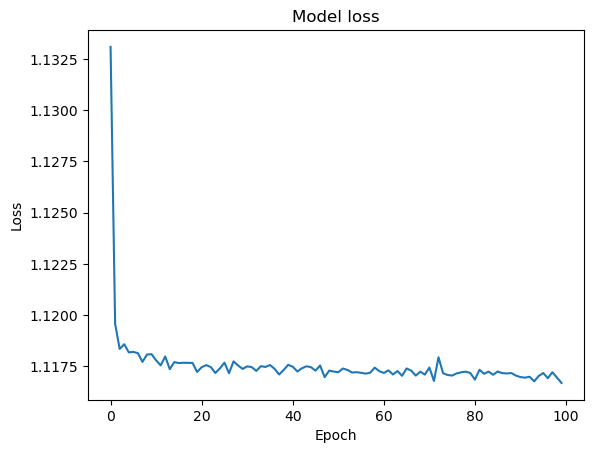

In [46]:
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show();

We achieved the basically the same performance with the other models earlier. It could be possible to improve the performance a bit more with hyperparameter tuning the ANN, however, it requires considerable time and effort. Would it be a better approach when we already have a good performance Linear Regression model which is very simple and fast? It is a design choice. We leave our official solution as LGBM + Linear Regression on top.